<a href="https://colab.research.google.com/github/mark-rtb/simple_recommendation/blob/master/Sentiment_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test task 2

For Text field in dataset for Amazon Fine Food Reviews (https://www.kaggle.com/snap/amazon-fine-food-reviews)  please create a mechanism to determine a review’s sentiment. 

# Загрузка данных

Чтобы получить доступ к данным с kaggle нужно создать API токен и загрузить его в colab

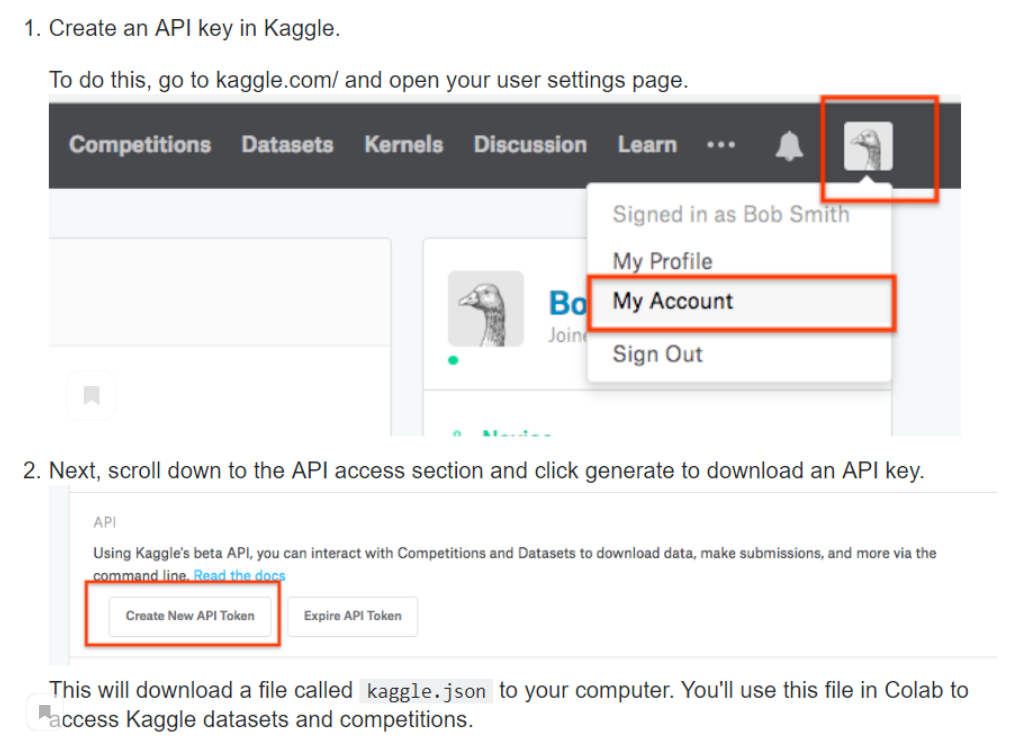

In [0]:
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from google.colab import files

In [4]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json
!pip install -q kaggle
!pip install -q kaggle-cli
!kaggle datasets download -d snap/amazon-fine-food-reviews


with zipfile.ZipFile('amazon-fine-food-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('amazon-fine-food-reviews')
    
os.chdir('amazon-fine-food-reviews')
print(os.listdir())

['Reviews.csv', 'OUTPUT_DIR_NAME', 'hashes.txt', 'database.sqlite']


# Подготовка данных

Для определения тональности отзыва нам необходимы только поля с текстом и оценки.


In [5]:
df_data=pd.read_csv("Reviews.csv")[['Score', 'Text']]
df_data.head()


,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


Чтобы упростить создание модели, сведем задачу анализа тональности к задаче бинарной классификации. 

В наборе данных оставляем только примеры с оценками 1,2 (отрицательные) и 4,5 (положительные)

In [0]:
df_data = df_data.loc[df_data['Score']!=3]
df_data['Score'] = df_data['Score'].apply(lambda x: 0 if x<=2 else 1)

In [7]:
print('процент положительных отзывов: {}'.format(df_data['Score'].mean()))

процент положительных отзывов: 0.843980951439102


#Описание модели

Чтобы добится высокого качества классификации, нужно применять достаточно сложные модели, состоящие из языковой модели и модели классификации. Однако, можно применить метод переноса обучения, и использовать веса уже обученной модели. При таком подходе можно за несколько эпох настроить модель на собственные данные, и получить хороший результат, быстро.

В качестве базовой модели будем использовать одну из лучших моделей на сегодняшний день - BERT. 

In [9]:
!pip install bert-tensorflow

In [10]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization



Определим **расположение** каталога для хранения выходных данных и контрольных точек нашей модели.

In [11]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'OUTPUT_DIR_NAME'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'BUCKET_NAME' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: OUTPUT_DIR_NAME *****


#Данные

так как даже дообучение модели на полном датасете занимает около суток, ограничим данные 20000 случайных примеров. И разделим их на тренировочную и валидационную выборки. 

In [0]:
_, df_data = train_test_split(df_data, test_size=20000, random_state=42) 
train, test = train_test_split(df_data, test_size=0.3, random_state=42) 

In [13]:
train.columns

Index(['Score', 'Text'], dtype='object')

Инициализируем переменные с названиями масивов данных

In [0]:
DATA_COLUMN = 'Text'
LABEL_COLUMN = 'Score'

label_list = [0, 1]

#Преобразование данных
Нам нужно преобразовать наши данные в формат, понятный модели. Это включает в себя два этапа. Во-первых, мы создаем входные примеры, используя конструктор, предоставленный в библиотеке BERT.



In [0]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Далее, мы должны предварительно обработать наши данные, чтобы они соответствовали данным, на которых обучался BERT.

1. приведем к нижнему регистру
2. токенизируем
3. разбиваем слова на части и добавляем
4. сопоставляем части слов со словарем BERT
5. добавляем маркеры  "CLS" и "SEP" в начало и конец предложения
6. Добавляем к каждому входу токены "index" и "segment"



In [16]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Используя токенизатор преобразуем тренировочную и тестовую последовательность

In [0]:
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

#Создание модели

функция create_model снова загружает модуль BERT_tf_hub, затем добавляется слой классификации.

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


Создаем функцию, которая выполняет обучение, оценку и предсказание.

Данные имеют существенный дисбаланс в сторону положительных отзывов. Поэтому, чтобы адекватно оценить модель, применим метрики не чувствительные к дисбалансу классов(ROC_AUC, F1_score) Дополнительно выведем часто используемые метрики (accuracy, precision, recall) И для наглядности выведем матрицу ошибок.


In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [0]:
BATCH_SIZE = 36
LEARNING_RATE = 1e-6
NUM_TRAIN_EPOCHS = 5.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.05
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [24]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'OUTPUT_DIR_NAME', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efd943ff240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'OUTPUT_DIR_NAME', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efd943ff240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}



Создаем функцию генератор, которая будет выполнять тренировку.

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Обучение модели



In [27]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


Training took time  0:00:00.012206


# Оцениваем модель на тестовых данных

In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [29]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-10T12:05:48Z


INFO:tensorflow:Starting evaluation at 2020-02-10T12:05:48Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-15500


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-15500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-10-12:06:23


INFO:tensorflow:Finished evaluation at 2020-02-10-12:06:23


INFO:tensorflow:Saving dict for global step 15500: auc = 0.9267298, eval_accuracy = 0.963, f1_score = 0.978011, false_negatives = 100.0, false_positives = 122.0, global_step = 15500, loss = 0.10150144, precision = 0.97588456, recall = 0.9801469, true_negatives = 841.0, true_positives = 4937.0


INFO:tensorflow:Saving dict for global step 15500: auc = 0.9267298, eval_accuracy = 0.963, f1_score = 0.978011, false_negatives = 100.0, false_positives = 122.0, global_step = 15500, loss = 0.10150144, precision = 0.97588456, recall = 0.9801469, true_negatives = 841.0, true_positives = 4937.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15500: OUTPUT_DIR_NAME/model.ckpt-15500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15500: OUTPUT_DIR_NAME/model.ckpt-15500


{'auc': 0.9267298,
 'eval_accuracy': 0.963,
 'f1_score': 0.978011,
 'false_negatives': 100.0,
 'false_positives': 122.0,
 'global_step': 15500,
 'loss': 0.10150144,
 'precision': 0.97588456,
 'recall': 0.9801469,
 'true_negatives': 841.0,
 'true_positives': 4937.0}

# Результаты

Показатели AUC ~ 0.93 и F1_score ~ 0.98 считаются достаточно высокими для подобных моделей. Поэтому данную модель можно успешно применять в реальной жизни.

# Выполнение предсказания

В качестве примера, создадим функцию предсказания тональности для новых отзывов.

Для примера возьмем 5 текстов из тестового набора.

In [0]:
def getPrediction(in_sentences):
  labels = [0, 1]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [0]:
pred_sentences = test.Text.values[:5]

In [58]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 5


INFO:tensorflow:Writing example 0 of 5


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i love this cha ##i tea ! ! its really delicious and it doesn ' t get that burnt taste if you leave the bag in too long . my husband doesn ' t even like tea but only requests this specific one . < br / > i love the individually packaged bags . worth the price ! [SEP]


INFO:tensorflow:tokens: [CLS] i love this cha ##i tea ! ! its really delicious and it doesn ' t get that burnt taste if you leave the bag in too long . my husband doesn ' t even like tea but only requests this specific one . < br / > i love the individually packaged bags . worth the price ! [SEP]


INFO:tensorflow:input_ids: 101 1045 2293 2023 15775 2072 5572 999 999 2049 2428 12090 1998 2009 2987 1005 1056 2131 2008 11060 5510 2065 2017 2681 1996 4524 1999 2205 2146 1012 2026 3129 2987 1005 1056 2130 2066 5572 2021 2069 11186 2023 3563 2028 1012 1026 7987 1013 1028 1045 2293 1996 14258 21972 8641 1012 4276 1996 3976 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2293 2023 15775 2072 5572 999 999 2049 2428 12090 1998 2009 2987 1005 1056 2131 2008 11060 5510 2065 2017 2681 1996 4524 1999 2205 2146 1012 2026 3129 2987 1005 1056 2130 2066 5572 2021 2069 11186 2023 3563 2028 1012 1026 7987 1013 1028 1045 2293 1996 14258 21972 8641 1012 4276 1996 3976 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] this product was discontinued in my local supermarket . a friend suggested i check amazon . com . thankfully i found it ! < br / > a great product for dip ##s , meat ##lo ##af and your favorite soup ##s . [SEP]


INFO:tensorflow:tokens: [CLS] this product was discontinued in my local supermarket . a friend suggested i check amazon . com . thankfully i found it ! < br / > a great product for dip ##s , meat ##lo ##af and your favorite soup ##s . [SEP]


INFO:tensorflow:input_ids: 101 2023 4031 2001 8944 1999 2026 2334 17006 1012 1037 2767 4081 1045 4638 9733 1012 4012 1012 16047 1045 2179 2009 999 1026 7987 1013 1028 1037 2307 4031 2005 16510 2015 1010 6240 4135 10354 1998 2115 5440 11350 2015 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2023 4031 2001 8944 1999 2026 2334 17006 1012 1037 2767 4081 1045 4638 9733 1012 4012 1012 16047 1045 2179 2009 999 1026 7987 1013 1028 1037 2307 4031 2005 16510 2015 1010 6240 4135 10354 1998 2115 5440 11350 2015 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i made a decision years ago to eat health ##ier , and one of the things that i gave up was peanut butter cups . however , i was over ##joy ##ed when i found p ##b ##2 with premium chocolate in my local grocery store ( i ' m also a big fan of the original p ##b ##2 , bt ##w ) . it is in essence peanut butter with 85 % less fat . < br / > < br / > the premise is that they roast the peanuts and then press out the majority of the oil before making the peanut powder . when you go to use p ##b ##2 , you add water for moisture to create a much [SEP]


INFO:tensorflow:tokens: [CLS] i made a decision years ago to eat health ##ier , and one of the things that i gave up was peanut butter cups . however , i was over ##joy ##ed when i found p ##b ##2 with premium chocolate in my local grocery store ( i ' m also a big fan of the original p ##b ##2 , bt ##w ) . it is in essence peanut butter with 85 % less fat . < br / > < br / > the premise is that they roast the peanuts and then press out the majority of the oil before making the peanut powder . when you go to use p ##b ##2 , you add water for moisture to create a much [SEP]


INFO:tensorflow:input_ids: 101 1045 2081 1037 3247 2086 3283 2000 4521 2740 3771 1010 1998 2028 1997 1996 2477 2008 1045 2435 2039 2001 21443 12136 10268 1012 2174 1010 1045 2001 2058 24793 2098 2043 1045 2179 1052 2497 2475 2007 12882 7967 1999 2026 2334 13025 3573 1006 1045 1005 1049 2036 1037 2502 5470 1997 1996 2434 1052 2497 2475 1010 18411 2860 1007 1012 2009 2003 1999 11305 21443 12136 2007 5594 1003 2625 6638 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 18458 2003 2008 2027 25043 1996 27613 1998 2059 2811 2041 1996 3484 1997 1996 3514 2077 2437 1996 21443 9898 1012 2043 2017 2175 2000 2224 1052 2497 2475 1010 2017 5587 2300 2005 14098 2000 3443 1037 2172 102


INFO:tensorflow:input_ids: 101 1045 2081 1037 3247 2086 3283 2000 4521 2740 3771 1010 1998 2028 1997 1996 2477 2008 1045 2435 2039 2001 21443 12136 10268 1012 2174 1010 1045 2001 2058 24793 2098 2043 1045 2179 1052 2497 2475 2007 12882 7967 1999 2026 2334 13025 3573 1006 1045 1005 1049 2036 1037 2502 5470 1997 1996 2434 1052 2497 2475 1010 18411 2860 1007 1012 2009 2003 1999 11305 21443 12136 2007 5594 1003 2625 6638 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 18458 2003 2008 2027 25043 1996 27613 1998 2059 2811 2041 1996 3484 1997 1996 3514 2077 2437 1996 21443 9898 1012 2043 2017 2175 2000 2224 1052 2497 2475 1010 2017 5587 2300 2005 14098 2000 3443 1037 2172 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the match ##a came promptly . there is plenty of it . those are the positive ##s . < br / > the color of the match ##a looks nothing like the photo . it is a deeper , darker more muted green . it tastes similar to what it looks - muddy , sort of like dirty , grassy , water . < br / > i have purchased much higher quality match ##a at very reasonable prices ( $ 18 . 00 for 8 ##oz . ) in japanese markets in nyc and l . a . i purchased this to drink every morning and to use in cooking and fra ##pp ##ucci ##nos . so far , it is best for fra ##pp [SEP]


INFO:tensorflow:tokens: [CLS] the match ##a came promptly . there is plenty of it . those are the positive ##s . < br / > the color of the match ##a looks nothing like the photo . it is a deeper , darker more muted green . it tastes similar to what it looks - muddy , sort of like dirty , grassy , water . < br / > i have purchased much higher quality match ##a at very reasonable prices ( $ 18 . 00 for 8 ##oz . ) in japanese markets in nyc and l . a . i purchased this to drink every morning and to use in cooking and fra ##pp ##ucci ##nos . so far , it is best for fra ##pp [SEP]


INFO:tensorflow:input_ids: 101 1996 2674 2050 2234 13364 1012 2045 2003 7564 1997 2009 1012 2216 2024 1996 3893 2015 1012 1026 7987 1013 1028 1996 3609 1997 1996 2674 2050 3504 2498 2066 1996 6302 1012 2009 2003 1037 6748 1010 9904 2062 22124 2665 1012 2009 16958 2714 2000 2054 2009 3504 1011 15405 1010 4066 1997 2066 6530 1010 22221 1010 2300 1012 1026 7987 1013 1028 1045 2031 4156 2172 3020 3737 2674 2050 2012 2200 9608 7597 1006 1002 2324 1012 4002 2005 1022 18153 1012 1007 1999 2887 6089 1999 16392 1998 1048 1012 1037 1012 1045 4156 2023 2000 4392 2296 2851 1998 2000 2224 1999 8434 1998 25312 9397 16835 15460 1012 2061 2521 1010 2009 2003 2190 2005 25312 9397 102


INFO:tensorflow:input_ids: 101 1996 2674 2050 2234 13364 1012 2045 2003 7564 1997 2009 1012 2216 2024 1996 3893 2015 1012 1026 7987 1013 1028 1996 3609 1997 1996 2674 2050 3504 2498 2066 1996 6302 1012 2009 2003 1037 6748 1010 9904 2062 22124 2665 1012 2009 16958 2714 2000 2054 2009 3504 1011 15405 1010 4066 1997 2066 6530 1010 22221 1010 2300 1012 1026 7987 1013 1028 1045 2031 4156 2172 3020 3737 2674 2050 2012 2200 9608 7597 1006 1002 2324 1012 4002 2005 1022 18153 1012 1007 1999 2887 6089 1999 16392 1998 1048 1012 1037 1012 1045 4156 2023 2000 4392 2296 2851 1998 2000 2224 1999 8434 1998 25312 9397 16835 15460 1012 2061 2521 1010 2009 2003 2190 2005 25312 9397 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i love the fact that it is easy to put in lunch ##es and that it ' s organic - but my kids did not like the vanilla flavor - [SEP]


INFO:tensorflow:tokens: [CLS] i love the fact that it is easy to put in lunch ##es and that it ' s organic - but my kids did not like the vanilla flavor - [SEP]


INFO:tensorflow:input_ids: 101 1045 2293 1996 2755 2008 2009 2003 3733 2000 2404 1999 6265 2229 1998 2008 2009 1005 1055 7554 1011 2021 2026 4268 2106 2025 2066 1996 21161 14894 1011 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2293 1996 2755 2008 2009 2003 3733 2000 2404 1999 6265 2229 1998 2008 2009 1005 1055 7554 1011 2021 2026 4268 2106 2025 2066 1996 21161 14894 1011 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-15500


INFO:tensorflow:Restoring parameters from OUTPUT_DIR_NAME/model.ckpt-15500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


ЧТобы вывести оценку тональности в диаппазоне от 0 до 1. 
Применим к полученным результатам функцию SoftMax

In [0]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [0]:
list_pr=[]
for x in predictions:
  list_pr.append(softmax(np.array(x[1]))[1])


In [67]:
for position, score in enumerate(list_pr):
    print(f'Text:\n{pred_sentences[position]}\nscore: {score}\n\n')


Text:
i love this chai tea!!  its really delicious and it doesn't get that burnt taste if you leave the bag in too long.  my husband doesn't even like tea but only requests this specific one.<br />i love the individually packaged bags. worth the price!
score: 0.9989939332008362


Text:
This product was discontinued in my local supermarket. A friend suggested I check Amazon.com. Thankfully I found it!<br />  A great product for dips, meatloaf and your favorite soups.
score: 0.9981043934822083


Text:
I made a decision years ago to eat healthier, and one of the things that I gave up was peanut butter cups.  However, I was overjoyed when I found PB2 with Premium Chocolate in my local grocery store (I'm also a big fan of the original PB2, btw).  It is in essence peanut butter with 85% less fat.<br /><br />The premise is that they roast the peanuts and then press out the majority of the oil before making the peanut powder.  When you go to use PB2, you add water for moisture to create a much

# Заключение

Анализ тональности - это одна из наиболее популярных задачь в NLP. ПРименение архитектуры трансформеров и подходов с предварительным обучением языковых моделей, показывают лучшие результаты в данной задаче.

При желании, данную модель можно существенно улучшить:
1. Обучить на всех данных.
2. Дообучить языковую модель на доменной области текстов.
3. Обучить несколько моделей на кросс валидации и усреднить прогнозы, для новых данных.
4. добавить аугментации текстов (например путем перевода на другой язык и обратно)

В классическом подходе существенно улучшить точность помогает очистка и предподготовка данных, однако в случае с BERT'ом это дает не большой прирост, так как предобученная языковая модель и механизм внимания делает похожую очистку за нас.

